In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error

from src.mlhgp import MLHGP

In [2]:
def f1(X, add_noise=False):
    target = X * np.sin(X) + np.sqrt(16*X)
    if add_noise:
        rng = np.random.RandomState(1)
        target += rng.normal(0, 1, size=target.shape)
    return target.squeeze()

f2 = np.cos
transform = np.exp

# Test Data

In [3]:
X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)

# Compute loc and scale as functions of input X
loc = f1(X, add_noise=False).reshape(-1,1)
scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood
Y = np.random.normal(loc, scale)

# Training Data

In [4]:
rng = np.random.RandomState(0)
X_train = rng.uniform(0, 10, size=15).reshape(-1, 1)
mean_train = f1(X_train, add_noise=False).reshape(-1,1)
scale_train = transform(f2(X_train))

np.random.seed(17)
y_train = np.random.normal(mean_train, scale_train)

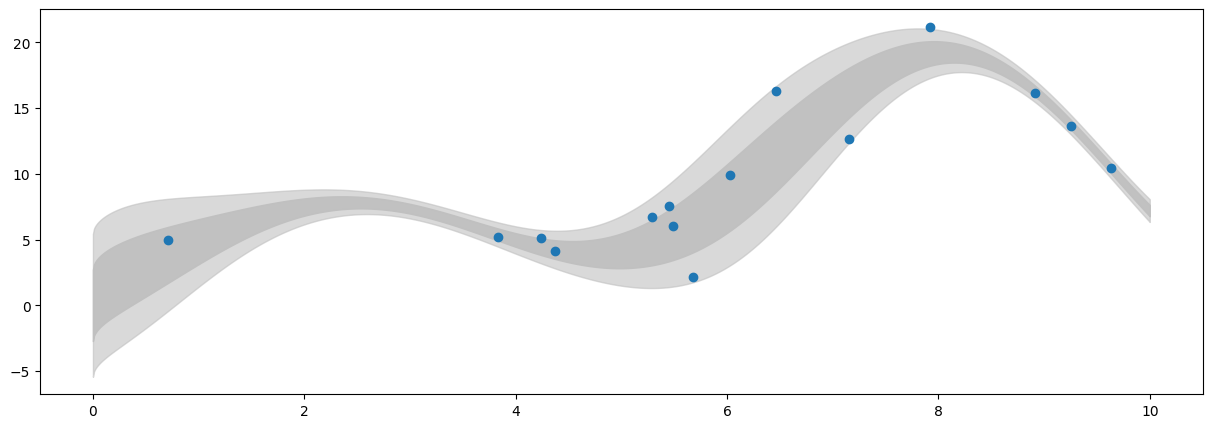

In [5]:
plt.figure(figsize=(15, 5))
x = X.squeeze()
for k in (1, 2):
    lb = (loc - k * scale).squeeze()
    ub = (loc + k * scale).squeeze()
    plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
plt.scatter(X_train, y_train)

# Most Likely Heteroscedastic Gaussian Process approach

In [6]:
# define the model
kernel = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1e1)
)
kernel_noise = ConstantKernel(1.0) * RBF(length_scale=1e1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1, noise_level_bounds=(1e-5, 1)
)

model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=25)
model_noise = GaussianProcessRegressor(kernel=kernel_noise, n_restarts_optimizer=25)

hgp = MLHGP(model, model_noise, max_iter=10)

# fit the model
hgp.fit(X_train, y_train.flatten(), print_noise_rmse=True)

# make a prediction 
Y_pred, Std_pred = hgp.predict(X, return_std="multi")

std_al, std_ep = Std_pred
std_tot = np.sqrt(std_al**2 + std_ep**2)

RMSE_noise = 0.581392126767171,
 pred_noise = [1.14203615 1.59372464 1.38378733 1.12270714 0.56304135 1.52265606
 0.61584111 0.98115842 0.62313079 0.43886157 1.43697621 1.04304494
 1.23414309 0.8079908  0.47778223], 
 target_noise = [0.78609438 2.01113208 0.66785955 0.74216919 0.80239403 2.33891232
 0.31792809 0.38793845 0.91050274 0.47111813 1.82314064 0.43803458
 2.74026475 0.69884525 0.73977818]
RMSE_noise = 0.5917828817031532,
 pred_noise = [0.95044989 1.66067381 1.33035535 0.92149623 0.20632761 1.55934214
 0.26102788 0.57689211 0.1262166  0.09500379 1.34275951 0.8046744
 1.09148952 0.33952139 0.24369326], 
 target_noise = [0.35911045 2.04159173 0.44440396 0.54563992 0.33675105 2.38591593
 0.21326584 0.21622424 0.25820903 0.05699893 1.82787134 0.48374117
 2.69364589 0.10533661 0.38723234]
RMSE_noise = 0.5984068340973796,
 pred_noise = [ 0.85241182  1.57276658  1.25526472  0.82192773  0.10611031  1.4944982
  0.15648416  0.35775403 -0.0501231   0.00860055  1.18132131  0.69960136
  1.

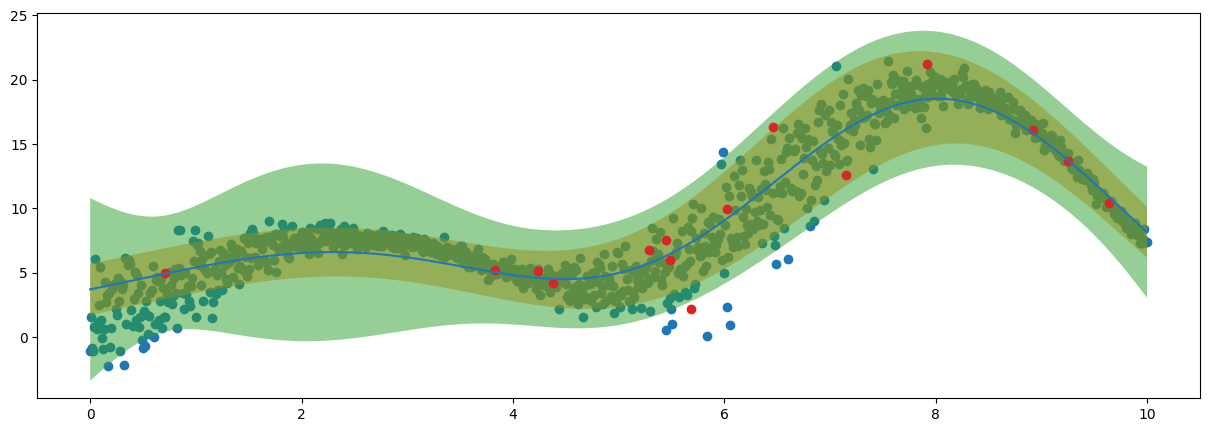

In [7]:
plt.figure(figsize=(15, 5))
plt.scatter(X,Y)
x = X.squeeze()
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * (std_al),
    Y_pred + 1.96 * (std_al),
    alpha=0.5,
    label=r"Observed data stdev",
)
plt.fill_between(
    X.ravel(),
    Y_pred - 1.96 * std_tot,
    Y_pred + 1.96 * std_tot,
    alpha=0.5,
    label=r"Prediction uncertainty",
)
plt.plot(X, Y_pred)
plt.scatter(X_train, y_train)